In [1]:
import numpy as np
import random
from trigger import *

<h3>Threshold estimate for trigger edge</h3>

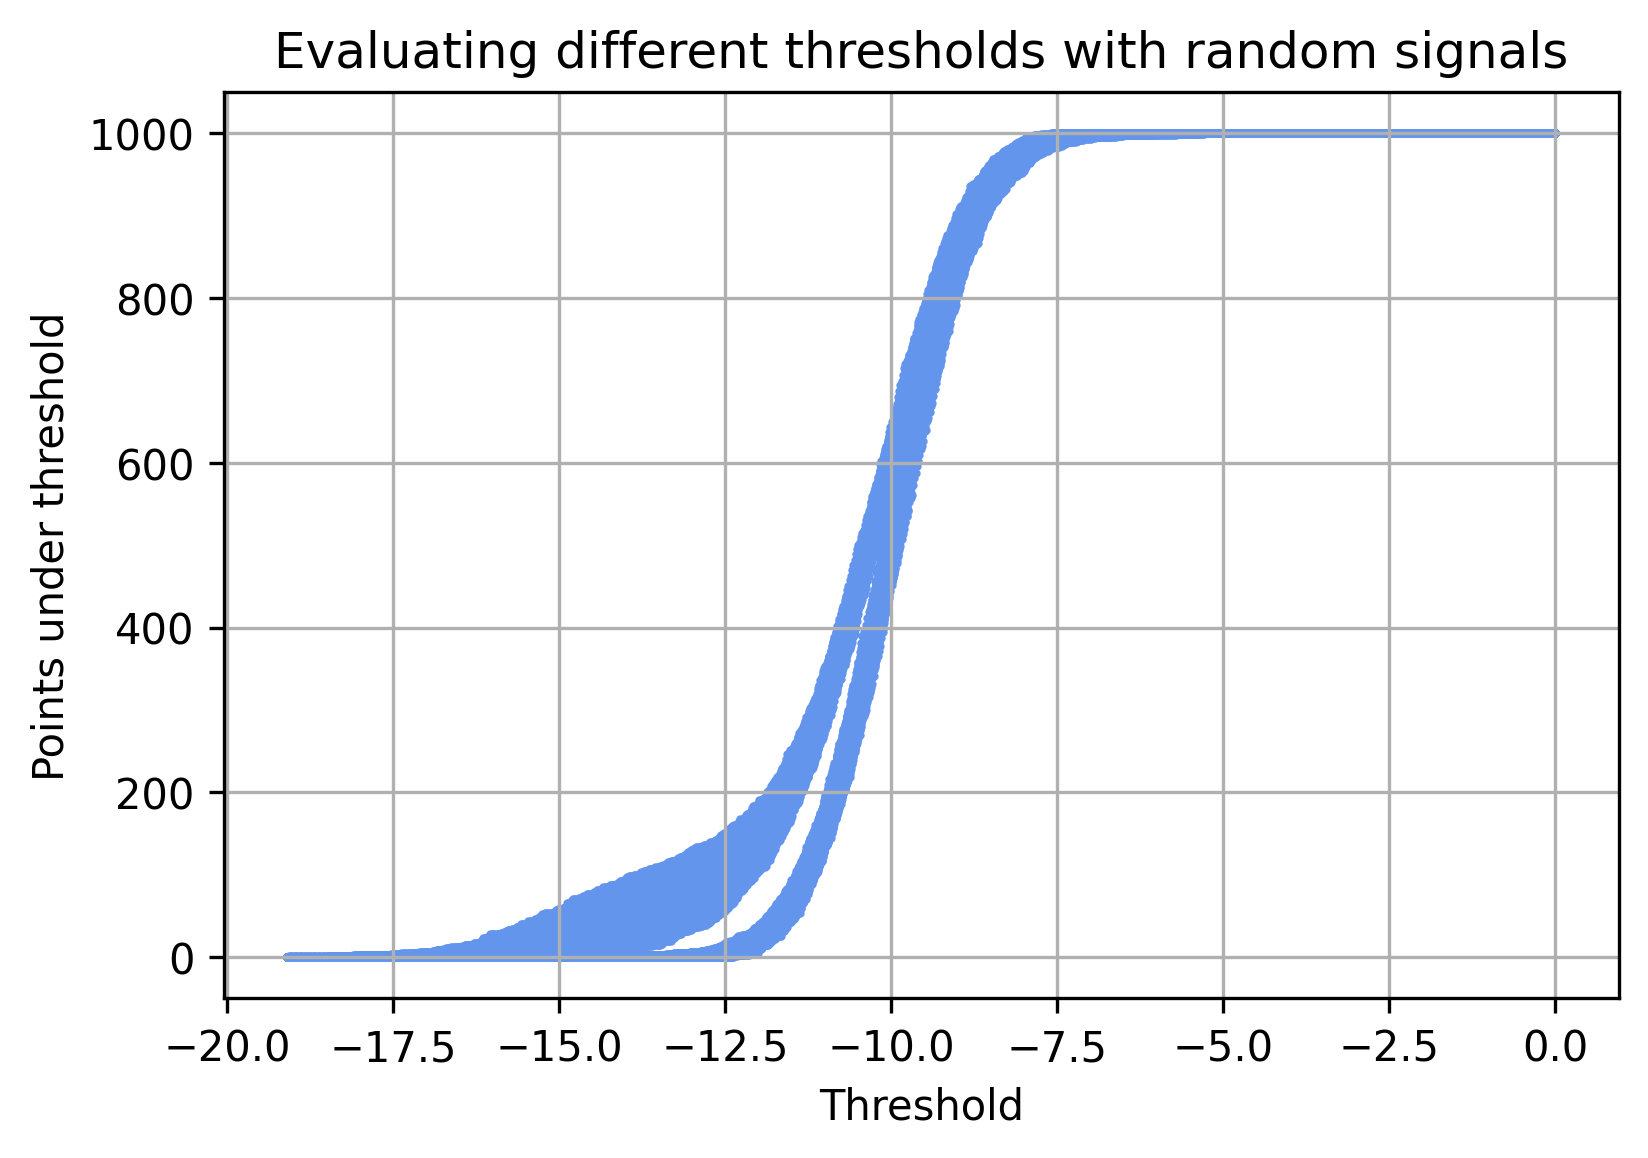

In [2]:
# How many random signals?
n_signals = 1000

# Initializations
signals = []
min = 0

# Generating random signals with amplitude in range 20 - 40 or only noise with 0.1 and 0.9 weights respectively.
for i in range(0, n_signals):
    signals.append(gen_signal(baseline=-10, amplitude=random.choices([random.randint(20, 40), 0], [0.1, 0.9]), noise_lev=1, plot=False, pulse_start=np.random.uniform(199.5,200.5)))
    min = signals[i].min() if signals[i].min() < min else min
# For the maximum threshold, I use the minimum value assumed among all signals.
threshold = np.linspace(0, min, n_signals)
counts = []
    
plt.figure(dpi = 300)

for i in range(0, n_signals):
    points = []

    # Counting how many points of a signal are below the threshold
    for thr in threshold:
        points.append(len(np.where(signals[i] < thr)[0]))
    plt.scatter(threshold, points, s=1, c='cornflowerblue') # Nice color

plt.title('Evaluating different thresholds with random signals')
plt.xlabel('Threshold')
plt.ylabel('Points under threshold')
plt.grid()
plt.show()

This code differenciates between signal and noise only to check the different trends.
The white region in the middle can be the location of the threshold because it's easy to distinguish between S and N

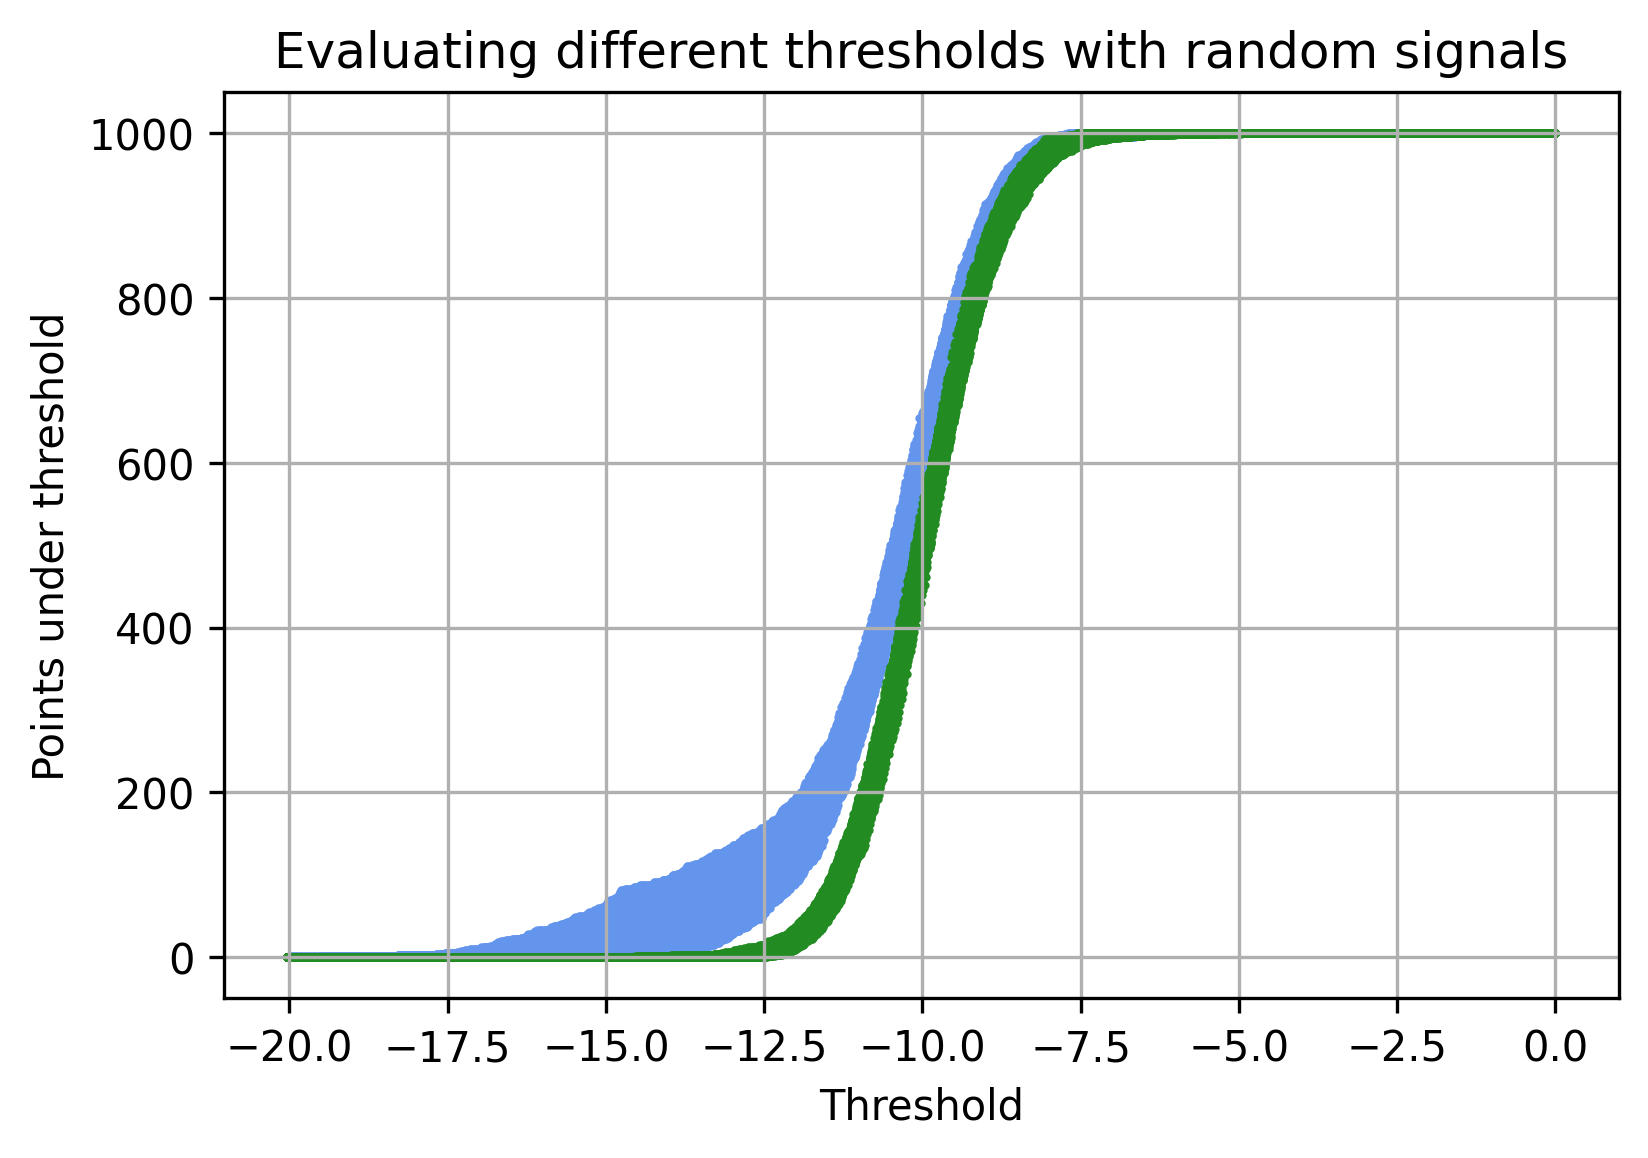

In [4]:
# How many signals and noises?
n_signals = 1000
n_noises = 1000

# Initializations
signals = []
noises = []
min = 0

# Generating random signals with amplitude in range 20 - 40 and only noise with level=1.
for i in range(0, n_signals):
    signals.append(gen_signal(baseline=-10, amplitude=random.randint(20,40), noise_lev=1, plot=False, pulse_start=np.random.uniform(199.5,200.5)))
    min = signals[i].min() if signals[i].min() < min else min
for i in range(0, n_noises):
    noises.append(gen_signal(baseline=-10, amplitude=0, noise_lev=1, plot=False, pulse_start=np.random.uniform(199.5,200.5)))

# For the maximum threshold, I use the minimum value assumed among all signals.
threshold = np.linspace(0, min, n_signals)
counts = []
    
plt.figure(dpi = 300)

for i in range(0, n_signals):
    points = []

    # Counting how many points of a signal are below the threshold
    for thr in threshold:
        points.append(len(np.where(signals[i] < thr)[0]))
    plt.scatter(threshold, points, s=1, c='cornflowerblue') # Nice color

for i in range(0, n_noises):
    points = []

    # Counting how many points of a signal are below the threshold
    for thr in threshold:
        points.append(len(np.where(noises[i] < thr)[0]))
    plt.scatter(threshold, points, s=1, c='forestgreen') # Nice color

plt.title('Evaluating different thresholds with random signals')
plt.xlabel('Threshold')
plt.ylabel('Points under threshold')
plt.grid()
plt.show()

The following code marks a waveform as a signal if it's over the threshold, regardless of the number of points above threshold. The region where the curve is flatter (plateau) is where we are triggering only signals and discharge the noise. It's quite difficult to find this region if signals are small.

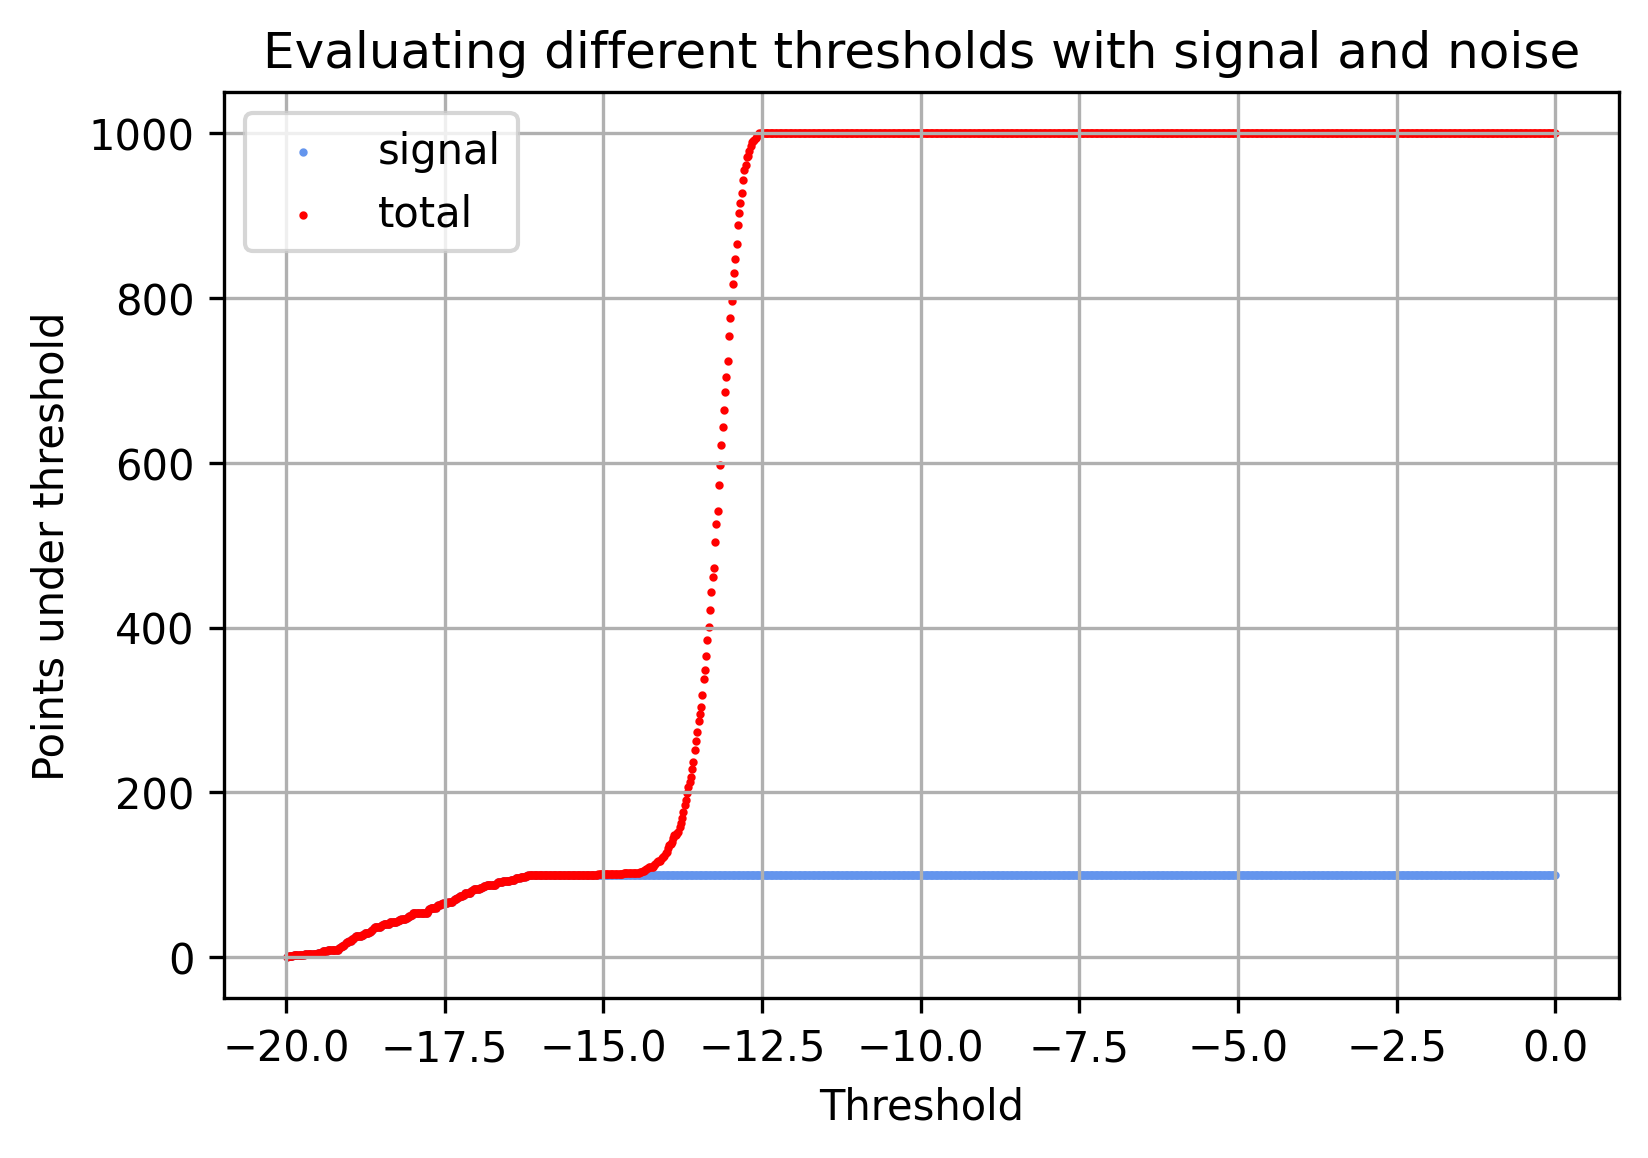

In [5]:
# How many signals and noises?
n_signals = 100
n_noises = 900

# Initializations
signals = []
noises = []
min = 0

# Generating random signals with amplitude in range 30 - 50 and only noise.
for i in range(0, n_signals):
    signals.append(gen_signal(baseline=-10, amplitude=random.randint(30,50), noise_lev=1, plot=False, pulse_start=np.random.uniform(199.5,200.5)))
    min = signals[i].min() if signals[i].min() < min else min
for i in range(0, n_noises):
    noises.append(gen_signal(baseline=-10, amplitude=0, noise_lev=1, plot=False, pulse_start=np.random.uniform(199.5,200.5)))

# For the maximum threshold, I use the minimum value assumed among all signals.
threshold = np.linspace(0, min, 1000)
s_counts = np.zeros(len(threshold))
n_counts = np.zeros(len(threshold))
    
plt.figure(dpi = 300)

#check if the signal/noise is under the threshold 
for i in range(0, n_signals):
    j=0
    for thr in threshold:
        if signals[i].min() < thr:
            s_counts[j] += 1
        j+=1

for i in range(0, n_noises):
    j=0
    for thr in threshold:
        if noises[i].min() < thr:
            n_counts[j] += 1
        j+=1            

tot_counts = s_counts + n_counts
 
plt.scatter(threshold, s_counts,   s=1, label = 'signal', c='cornflowerblue') # Nice color
#plt.scatter(threshold, n_counts,   s=1, label = 'noise',  c='forestgreen') # Nice color
plt.scatter(threshold, tot_counts, s=1, label = 'total',  c='red') # Nice color

plt.title('Evaluating different thresholds with signal and noise')
plt.xlabel('Threshold')
plt.ylabel('Points under threshold')
plt.legend()
plt.grid()
plt.show()

In [54]:
s_counts = 0
n_counts = 0
thr = -14.9
    
for i in range(0, n_signals):
    if signals[i].min() < thr:
        s_counts += 1

for i in range(0, n_noises):
    if noises[i].min() < thr:
        n_counts += 1
  
print('Number of signals over threshold: ', s_counts)
print('Number of noises over threshold: ',  n_counts)

Number of signals over threshold:  100
Number of noises over threshold:  0


In the real situation, not knowing which are signal and which are not, we'll look at the plateau at -15 and we'll put the threshold in the middle of the plateau.

<h3>Threshold estimate for derivative trigger</h3>

Same trigger as before but on the second derivative. It doesn't work yet..

In [60]:
def derivative_trigger_matrix2(sample, window_ma=15, poly=3, n=2, mv='convolve', vertex = False, plot=False): #now sample is a matrix of all of the samples
    
    if mv == 'convolve':
        weights = np.full((1, window_ma), 1/window_ma)
        moving_averages = convolve(sample, weights, mode='mirror')

    if mv == 'cumsum':
        moving_averages = moving_average(sample, window_ma)

    index_mins = []
    minimum = []
    for ii in range(len(sample)):
        time = np.linspace(0,len(sample[ii]), len(sample[ii]))

        # Plot after moving average 
        if plot:
            plt.plot(time, moving_averages[ii])
            print('Sample: ', ii)
            plt.show()

        first_derivative = np.gradient(moving_averages[ii])
        std = np.std(first_derivative[0:100])/2 #100 will become a function of length and pos_ref in pxie
        index_min = first_derivative.argmin()

        #print('index_min = ', index_min)
        
        rise_points = 0
        while first_derivative[index_min - rise_points] < -std:
            rise_points += 1
        
        #print('rise_points = ', rise_points)

        a = 10 #to have a window_length of 21, in this way all the windows are equal
        b = a // 2
        start = index_min - rise_points

        if start < a:
            start = a
        if start > len(sample[ii])-a:
            start = len(sample[ii])-1-a
        
        end = start + a + 1     # +1 to avoid the error: "window_length must be odd."
        begin = start - a if start - a > 0 else 0 # To avoid negative values for begin
        
        #print('hint start = %d, begin = %d, end = %d' %(start, begin, end))
        
        window_length = len(sample[ii][begin:end]) - 1 if len(sample[ii][begin:end]) % 2 == 0 else len(sample[ii][begin:end])

        #print(window_length)

        #poly_order = window_length-1 if window_length < 14 else 12
        
        derivative_func = savgol_filter(sample[ii][begin:end], window_length, poly, n, delta=1) #8 is the best in the tests done

        '''if plot:
            plt.scatter(time[begin+b:end-b], derivative_func[b:-b], color="g")
            plt.xlabel('Time [$\mu$s]')
            plt.ylabel('Voltage [mV]')
            plt.grid()
            plt.show()'''

        x2 = begin+b+(derivative_func[b:-b].argmin())
        if vertex:
            y1 = derivative_func[b+derivative_func[b:-b].argmin() - 1]
            y2 = derivative_func[b+derivative_func[b:-b].argmin()]
            y3 = derivative_func[b+derivative_func[b:-b].argmin() + 1]
            min = vertex_parabola(x2, y1, y2, y3)
        else:
            min = x2
        #min = begin+b+(derivative_func[b:-b].argmin())
        # we have to drop the first b points and the last b points of the array
        # since sth strange happens here with the derivative due to the polinomial fitting of sav_gol
        index_mins.append(min)
        minimum.append(derivative_func[b+derivative_func[b:-b].argmin()])

    return minimum

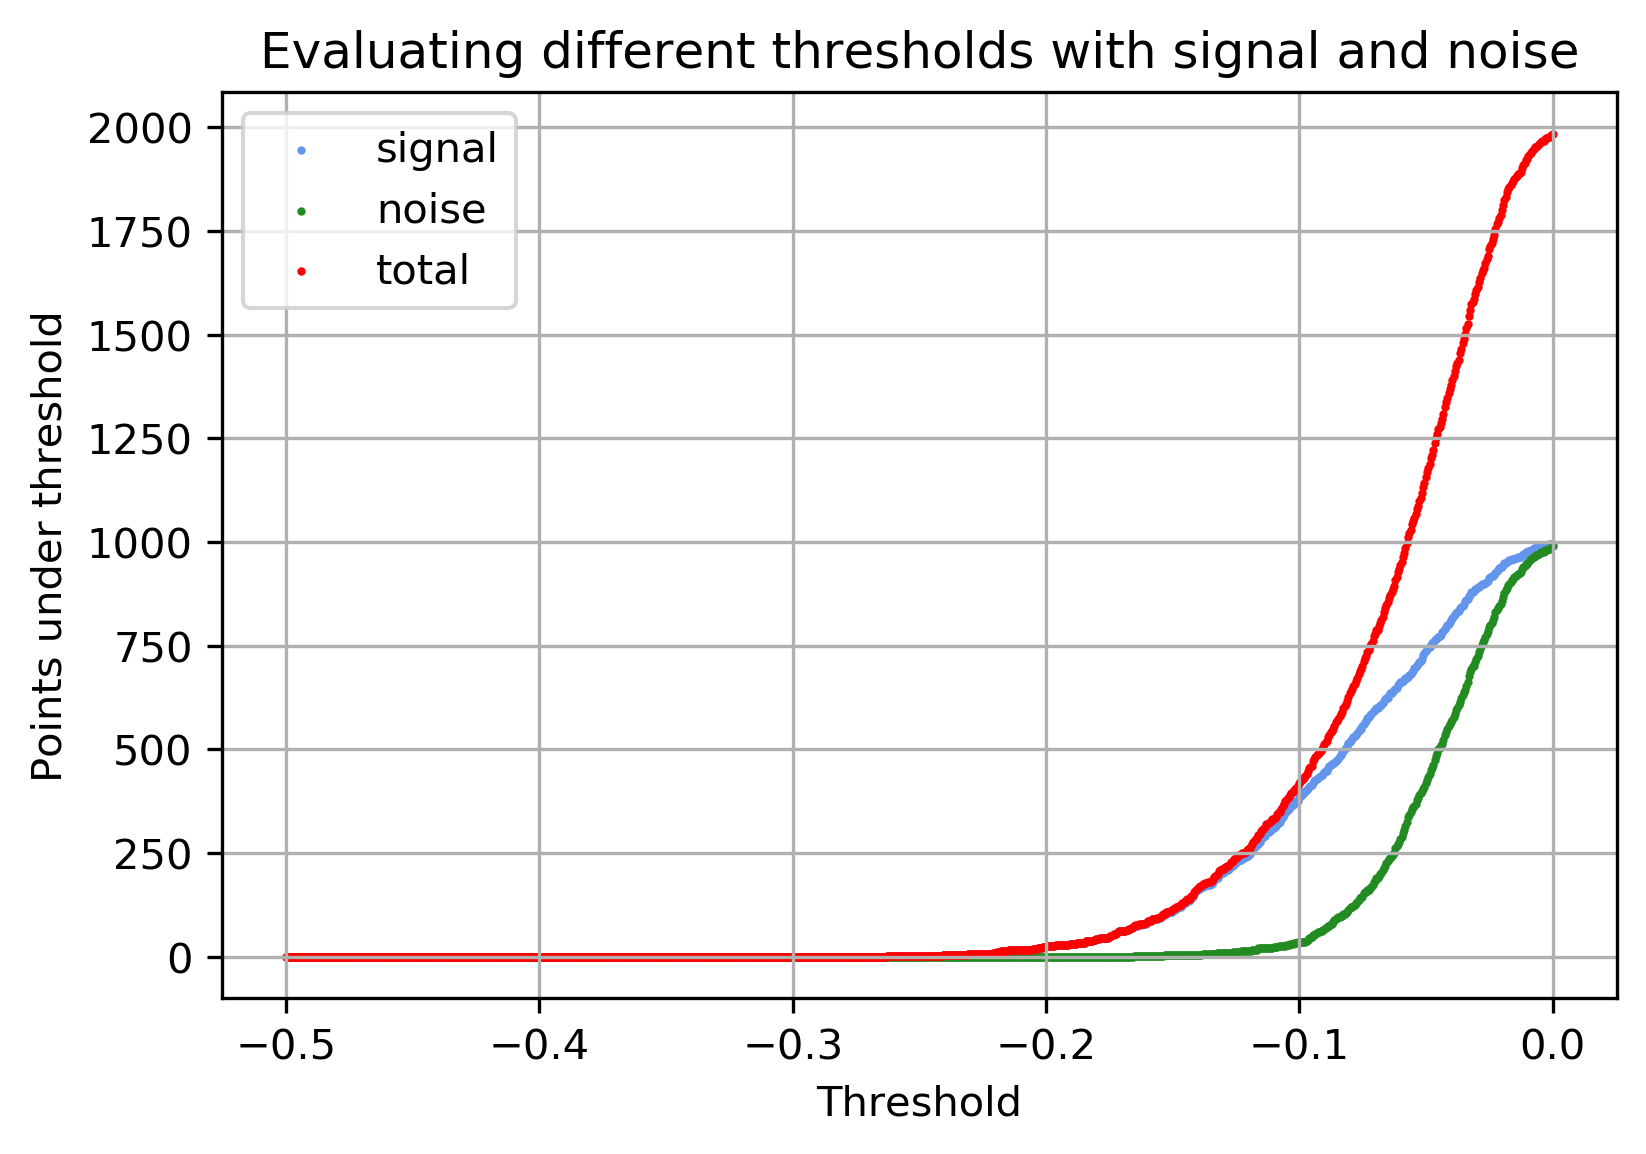

In [65]:
# How many random signals?
n_signals = 1000
n_noises = 1000

# Initializations
signals = []
noises = []
min = -0.5

# Generating random signals with amplitude in range 20 - 40 or only noise with 0.1 and 0.9 weights respectively.
for i in range(0, n_signals):
    signals.append(gen_signal(baseline=-10, amplitude=random.randint(100,200), noise_lev=1, plot=False, pulse_start=np.random.uniform(199.5,200.5)))
    #min = signals[i].min() if signals[i].min() < min else min
for i in range(0, n_noises):
    noises.append(gen_signal(baseline=-10, amplitude=0, noise_lev=1, plot=False, pulse_start=np.random.uniform(199.5,200.5)))

s_minimum = derivative_trigger_matrix2(signals)
n_minimum = derivative_trigger_matrix2(noises)

# For the maximum threshold, I use the minimum value assumed among all signals.
threshold = np.linspace(0, min, 1000)
s_counts = np.zeros(len(threshold))
n_counts = np.zeros(len(threshold))
    
plt.figure(dpi = 300)

for i in range(0, n_signals):
    j=0
    for thr in threshold:
            if s_minimum[i].min() < thr:
                s_counts[j] += 1
            j+=1

for i in range(0, n_noises):
    j=0
    for thr in threshold:
            if n_minimum[i].min() < thr:
                n_counts[j] += 1
            j+=1            

tot_counts = s_counts + n_counts

plt.scatter(threshold, s_counts,   s=1, label = 'signal', c='cornflowerblue') # Nice color
plt.scatter(threshold, n_counts,   s=1, label = 'noise',  c='forestgreen') # Nice color
plt.scatter(threshold, tot_counts, s=1, label = 'total',  c='red') # Nice color

plt.title('Evaluating different thresholds with signal and noise')
plt.xlabel('Threshold')
plt.ylabel('Points under threshold')
plt.legend()
plt.grid()
plt.show()

In [59]:
s_counts = 0
n_counts = 0
thr = -0.1
    
for i in range(0, n_signals):
    if s_minimum[i].min() < thr:
        s_counts += 1

for i in range(0, n_noises):
    if n_minimum[i].min() < thr:
        n_counts += 1
  
print('Number of signals over threshold: ', s_counts)
print('Number of noises over threshold: ',  n_counts)

Number of signals over threshold:  5
Number of noises over threshold:  129


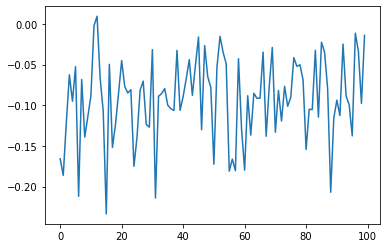

In [64]:
plt.plot(s_minimum)